In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import datasets from google drive
from google.colab import drive
drive.mount('/content/drive')

houseSales = pd.read_csv('/content/drive/MyDrive/projects/forcasting/new_one_family_houses.csv')
houseSales.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Sales
0,1963-01-01,591.0
1,1963-02-01,464.0
2,1963-03-01,461.0
3,1963-04-01,605.0
4,1963-05-01,586.0


In [3]:
scaler = MinMaxScaler()
houseSaleScaled = scaler.fit_transform(houseSales.Sales.values.reshape(-1, 1))
houseSales['HouseSalesScaled'] = houseSaleScaled

In [4]:
houseSales.describe()

,Sales,HouseSalesScaled
count,697.000000,697.000000
mean,654.005739,0.343169
std,211.685830,0.189174
min,270.000000,0.000000
25%,510.000000,0.214477
50%,625.000000,0.317248
75%,767.000000,0.444147
max,1389.000000,1.000000


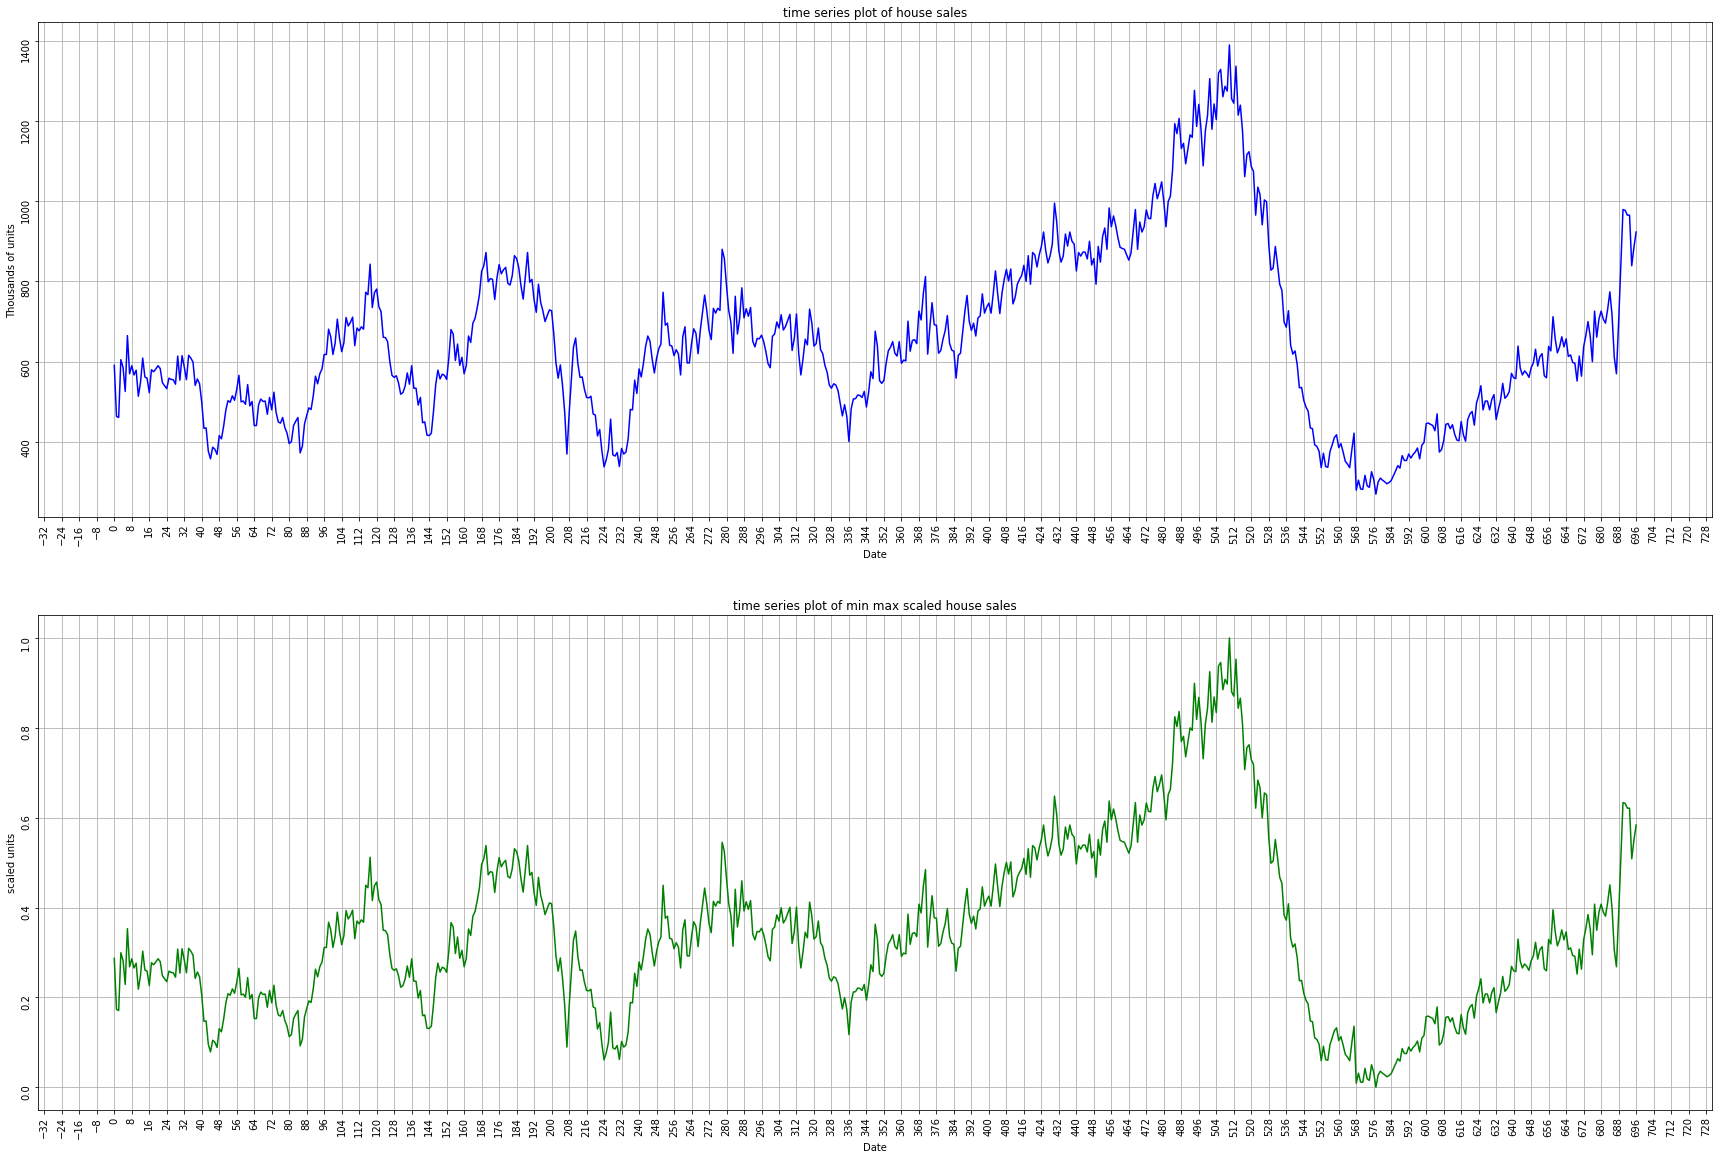

In [5]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15) # Adjust the padding between and around subplots

M = 100
xticks = ticker.MaxNLocator(M)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(houseSales.index, houseSales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of units')
ax1.title.set_text('time series plot of house sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(houseSales.index, houseSales.HouseSalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('scaled units')
ax2.title.set_text('time series plot of min max scaled house sales')
ax2.grid(True)



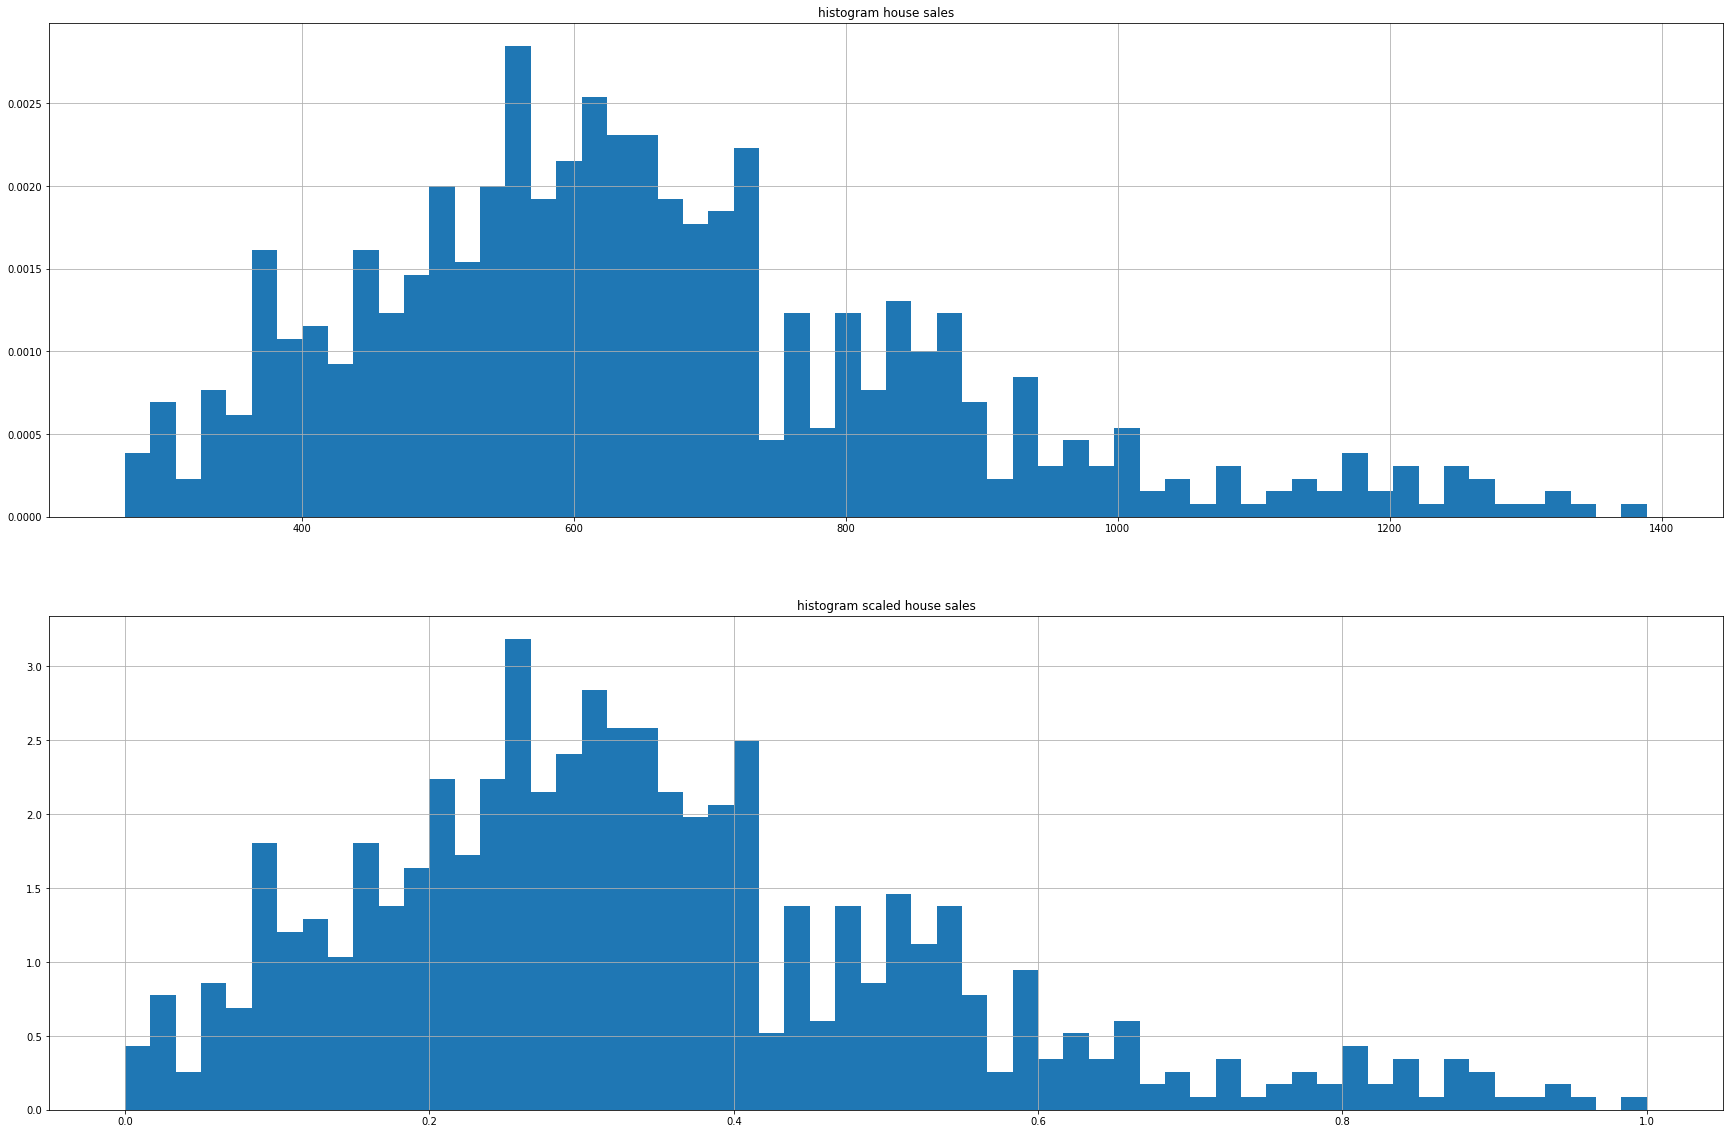

In [6]:
# the histogram of the house sales

fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(houseSales.Sales, density=True, bins=60)
ax1.title.set_text('histogram house sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(houseSales.HouseSalesScaled, density=True, bins=60)
ax2.title.set_text('histogram scaled house sales')
ax2.grid(True)

In [7]:
# unit root test and autocorrelogram
result = adfuller(houseSales.Sales.values, autolag='AIC')
print(f'ADF test statistics: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
  print('critical values:')
  print(f'    {key} : {value}')

ADF test statistics: -2.8085520725549906
p-value: 0.05706251126952945
critical values:
    1% : -3.4400605106273368
critical values:
    5% : -2.865824986587412
critical values:
    10% : -2.5690518865761


In [8]:
result = adfuller(houseSales.HouseSalesScaled.values, autolag='AIC')
print(f'ADF test statistics: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
  print('critical values:')
  print(f'    {key} : {value}')

ADF test statistics: -2.808552072555018
p-value: 0.05706251126952565
critical values:
    1% : -3.4400605106273368
critical values:
    5% : -2.865824986587412
critical values:
    10% : -2.5690518865761


In [9]:
acfSalesScaled = acf(houseSales.HouseSalesScaled, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

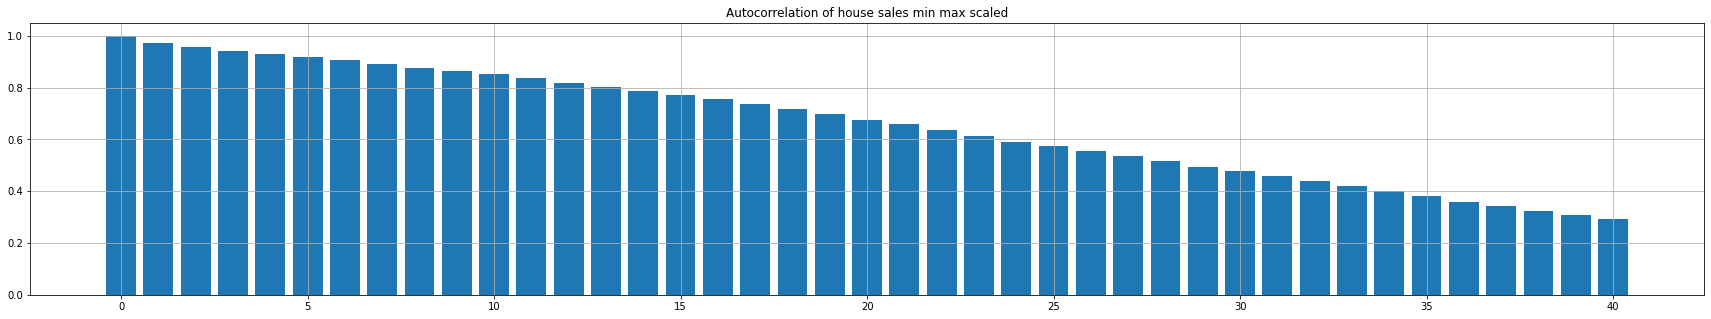

In [10]:
plt.figure(figsize=(30, 5))
plt.title('Autocorrelation of house sales min max scaled')
plt.bar(range(len(acfSalesScaledNp)), acfSalesScaledNp)
plt.grid(True)

plt.savefig('autocorrelation.png')
plt.show()

In [11]:
pacfSalesScaled = pacf(houseSales.HouseSalesScaled, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

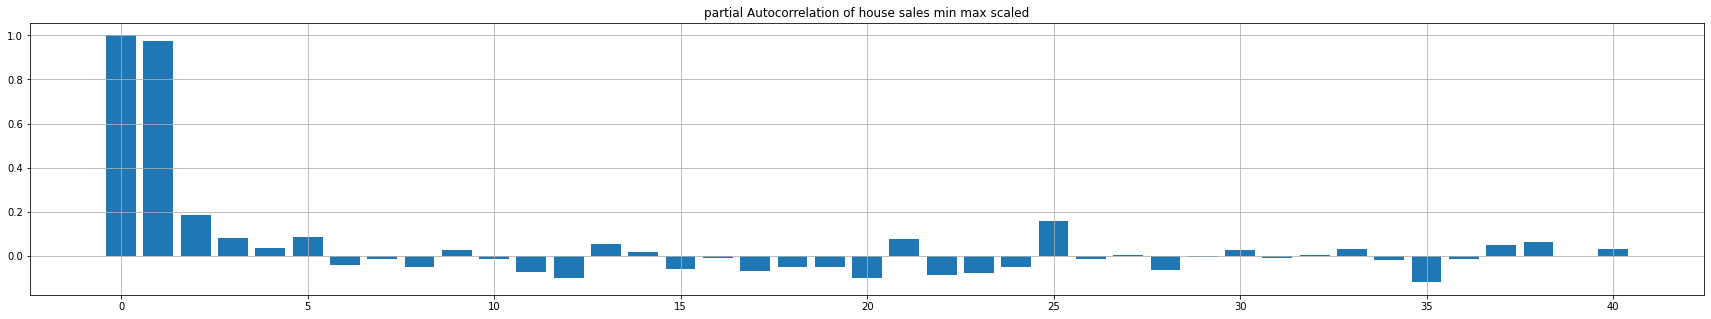

In [12]:
plt.figure(figsize=(30, 5))
plt.title('partial Autocorrelation of house sales min max scaled')
plt.bar(range(len(pacfSalesScaledNp)), pacfSalesScaledNp)
plt.grid(True)

plt.savefig('partial_autocorrelation.png')
plt.show()

In [13]:
SIZE = len(houseSales.HouseSalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - WINDOW_SIZE*2
EPOCHS = 200

In [14]:
# seperate data to train and validation data

DateTrain = houseSales.index.values[0:BATCH_SIZE]
DateValid = houseSales.index.values[BATCH_SIZE:]
XTrain = houseSales.HouseSalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = houseSales.HouseSalesScaled.values[BATCH_SIZE:].astype('float32')

# obtain shapes for vectors of size (, 1) for dates series
DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (601, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (601,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [15]:
tf.random.set_seed(1234)

def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


Dataset_train = windowed_dataset(XTrain)
Dataset_valid = windowed_dataset(XValid)



In [16]:
# LSTM estimation and forecating
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(8, input_shape=[None, 1], return_sequences=True),
                                    tf.keras.layers.LSTM(4, input_shape=[None, 1]),
                                    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='huber_loss')
history = model.fit(Dataset_train, epochs=EPOCHS, validation_data=Dataset_valid, verbose=1)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1456 - val_loss: 0.1189
Epoch 2/200
1/1 [==============================] - 0s 90ms/step - loss: 0.1408 - val_loss: 0.1146
Epoch 3/200
1/1 [==============================] - 0s 90ms/step - loss: 0.1362 - val_loss: 0.1104
Epoch 4/200
1/1 [==============================] - 0s 92ms/step - loss: 0.1316 - val_loss: 0.1063
Epoch 5/200
1/1 [==============================] - 0s 96ms/step - loss: 0.1272 - val_loss: 0.1024
Epoch 6/200
1/1 [==============================] - 0s 105ms/step - loss: 0.1230 - val_loss: 0.0986
Epoch 7/200
1/1 [==============================] - 0s 104ms/step - loss: 0.1189 - val_loss: 0.0949
Epoch 8/200
1/1 [==============================] - 0s 92ms/step - loss: 0.1149 - val_loss: 0.0913
Epoch 9/200
1/1 [==============================] - 0s 91ms/step - loss: 0.1110 - val_loss: 0.0879
Epoch 10/200
1/1 [==============================] - 0s 89ms/step - loss: 0.1073 - val_loss: 0.0845
Epoch 11/200
1/1 [=

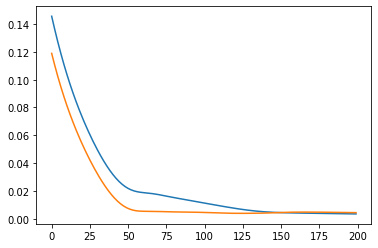

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [19]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

Forecast = model_forecast(model, houseSales.HouseSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE: -1]
Results1 = scaler.inverse_transform(Results.reshape(-1, 1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1, 1))

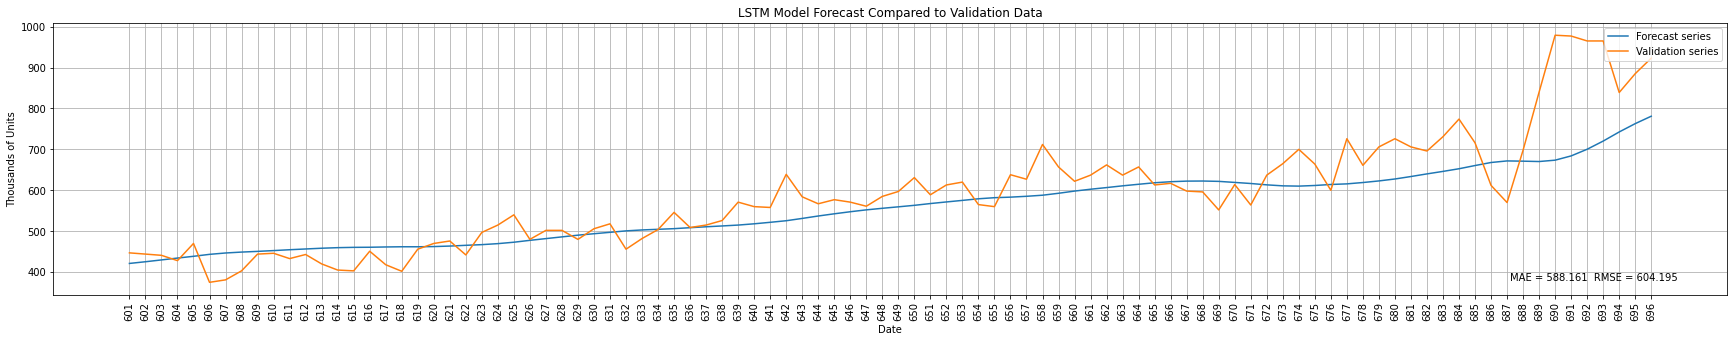

In [20]:
plt.figure(figsize=(30, 5))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid, Results1, label='Forecast series')
plt.plot(DateValid, np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()